In [3]:
import os
try:
    import cv2
except ImportError:
    print("Switch to other environment for image processing.")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks

Switch to other environment for image processing.


# Displacement - Analog Pressure DF


In [4]:
if os.path.exists("csv/Pneumatactors_Characterization.csv"):
    print("✅ Pneumatactors_Characterization.csv already exists. Skipping execution.")
else:
    print("Running full processing pipeline...")

    # --- PRESSURE DATA PROCESSING ---

    analog_root = "Analog Data"

    def voltage_to_pressure(vout):
        return (vout / 5 - 0.04) / 0.009

    pressure_results = []
    csv_files = sorted([
        f for f in os.listdir(analog_root)
        if f.endswith('.csv') and not f.startswith('.')
    ])

    for fname in csv_files:
        try:
            freq, pwm = fname.replace('.csv', '').split('_')
            freq = int(freq)
            pwm = int(pwm)
        except:
            print(f"Skipping malformed filename: {fname}")
            continue

        path = os.path.join(analog_root, fname)
        try:
            df = pd.read_csv(path)
            if 'Channel_3' not in df or 'Channel_4' not in df or 'Time' not in df:
                print(f"Missing expected columns in {fname}")
                continue

            # Detect where camera trigger (Channel_4) goes high
            camera_on = df['Channel_4'] >= 4.5
            if not camera_on.any():
                print(f"No camera trigger found in {fname}")
                continue

            start_idx = camera_on.idxmax()
            start_time = df.loc[start_idx, 'Time']
            end_time = start_time + 0.5  # 500 frames at 1000fps

            recording = df[(df['Time'] >= start_time) & (df['Time'] <= end_time)]
            if len(recording) < 10:
                print(f"⚠️ Too few samples in {fname}")
                continue

            vout = recording['Channel_3'].values
            pressure = voltage_to_pressure(vout)

            pressure_results.append({
                "frequency": freq,
                "pump_pwm": pwm,
                "mean_pressure": np.mean(pressure),
                "max_pressure": np.max(pressure),
                "min_pressure": np.min(pressure),
                "amplitude_pressure": np.max(pressure) - np.min(pressure)
            })

        except Exception as e:
            print(f"Error in {fname}: {e}")

    pressure_df = pd.DataFrame(pressure_results)
    pressure_df = pressure_df.sort_values(by=["frequency", "pump_pwm"]).reset_index(drop=True)


    # --- DISPLACEMENT DATA PROCESSING ---

    image_root = "Photron Images"
    fps = 1000

    def process_folder(folder_path, crop_yx=((480,600),(455,535)), thresholds=(5,120)):
        displacements = []
        folder_name = os.path.basename(folder_path)

        for img in range(1, 501):
            for ext in [".bmp", ".png"]:
                filename = os.path.join(folder_path, folder_name + str(img).zfill(6) + ext)
                if os.path.exists(filename):
                    break
            else:
                continue 

            image = cv2.imread(filename)
            if image is None:
                continue

            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            cropped = gray[crop_yx[0][0]:crop_yx[0][1], crop_yx[1][0]:crop_yx[1][1]]
            blurred = cv2.GaussianBlur(cropped, (5, 5), 0)
            edges = cv2.Canny(blurred, thresholds[0], thresholds[1])

            edge_points = np.column_stack(np.where(edges > 0))
            if edge_points.size == 0:
                continue

            ys = edge_points[:, 0]

            try:
                avg_bottom_y = np.mean(ys[ys > (edges.shape[0] - 20)])
                avg_middle_y = np.mean(ys[(ys > 40) & (ys < 60)])
                peak_top_y = np.min(ys[ys < 40])
                pixels_per_mm = (avg_bottom_y - avg_middle_y) / 7.2
                top_distance_mm = (avg_middle_y - peak_top_y) / pixels_per_mm
                displacements.append(top_distance_mm)
            except:
                continue

        return displacements

    disp_results = []
    folder_list = sorted([
        f for f in os.listdir(image_root)
        if os.path.isdir(os.path.join(image_root, f)) and not f.startswith('.')
    ])

    for folder_name in folder_list:
        print(f"Processing displacement for: {folder_name}")
        folder_path = os.path.join(image_root, folder_name)

        try:
            freq, pwm, _ = folder_name.split('_')
            freq = int(freq)
            pwm = int(pwm)
        except:
            print(f"Skipping invalid folder name: {folder_name}")
            continue

        disp = process_folder(folder_path)
        if len(disp) > 0:
            disp_results.append({
                "frequency": freq,
                "pump_pwm": pwm,
                "mean_disp_mm": np.mean(disp),
                "max_disp_mm": np.max(disp),
                "min_disp_mm": np.min(disp),
                "amplitude_mm": np.max(disp) - np.min(disp),
                "n_frames": len(disp)
            })

    disp_df = pd.DataFrame(disp_results)
    disp_df = disp_df.sort_values(by=["frequency", "pump_pwm"]).reset_index(drop=True)


    # --- MERGE PRESSURE + DISPLACEMENT ---

    final_df = pd.merge(disp_df, pressure_df, on=["frequency", "pump_pwm"], how="outer")
    final_df = final_df.sort_values(by=["frequency", "pump_pwm"]).reset_index(drop=True)

    # Save to CSV
    final_df.to_csv("csv/Pneumatactors_Characterization.csv", index=False)

✅ Pneumatactors_Characterization.csv already exists. Skipping execution.


# Valve Frequency - Displacement Frequency DF


In [5]:
if os.path.exists("csv/Pneumatactors_Characterization_FrequencyValidation.csv"):
    print("✅ Pneumatactors_Characterization_FrequencyValidation.csv already exists. Skipping execution.")
else:
    print("Running full processing pipeline...")

    image_root = "Photron Images"
    camera = "C001H001S0001"
    pump_pwm = 200
    fps = 1000

    results = []

    folder_list = sorted([
        f for f in os.listdir(image_root)
        if f.endswith(camera) and f.split('_')[1] == str(pump_pwm).zfill(3)
    ])

    for folder_name in folder_list:
        try:
            frequency = int(folder_name.split('_')[0])
        except:
            print(f"Skipping malformed folder: {folder_name}")
            continue

        print(f"Processing frequency {frequency} Hz...")

        base_file = f"{str(frequency).zfill(3)}_{str(pump_pwm).zfill(3)}_{camera}"
        folder = os.path.join(image_root, base_file)

        top_distances_mm = []
        valid_times = []

        for img in range(1, 501):
            filename = os.path.join(folder, base_file + str(img).zfill(6) + ".bmp")
            if not os.path.exists(filename):
                filename = os.path.join(folder, base_file + str(img).zfill(6) + ".png")
                if not os.path.exists(filename):
                    continue

            image = cv2.imread(filename)
            if image is None:
                continue

            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            cropped = gray[480:600, 455:535]
            blurred = cv2.GaussianBlur(cropped, (5, 5), 0)
            edges = cv2.Canny(blurred, threshold1=5, threshold2=130)

            edge_points = np.column_stack(np.where(edges > 0))
            if edge_points.size == 0:
                continue

            ys = edge_points[:, 0]

            try:
                avg_bottom_y = np.mean(ys[ys > (edges.shape[0] - 20)])
                avg_middle_y = np.mean(ys[(ys > 40) & (ys < 60)])
                peak_top_y = np.min(ys[ys < 40])
                pixels_per_mm = (avg_bottom_y - avg_middle_y) / 7.2
                top_distance_mm = (avg_middle_y - peak_top_y) / pixels_per_mm

                top_distances_mm.append(top_distance_mm)
                valid_times.append(img / fps)
            except:
                continue

        # Frequency estimation via peaks
        disp_freq = np.nan
        if len(top_distances_mm) > 20:
            smoothed = savgol_filter(top_distances_mm, window_length=11, polyorder=3)
            if frequency > 100:
                prominence = 0.01
            elif frequency < 10:
                prominence = 0.5
            else:
                prominence = 0.1
            peaks, _ = find_peaks(smoothed, distance=5, height=1.8, prominence=prominence)
            peak_times = np.array(valid_times)[peaks]

            if len(peak_times) > 1:
                intervals = np.diff(peak_times)
                mean_period = np.mean(intervals)
                disp_freq = 1 / mean_period

        if np.isnan(disp_freq):
            disp_freq = 0

        results.append({
            "valve_freq_hz": frequency,
            "disp_freq_hz": disp_freq
        })
        print(f"Frequency: {frequency} Hz, Disp. Frequency: {disp_freq:.2f} Hz")

    # Create DataFrame
    df = pd.DataFrame(results)
    df = df.sort_values("valve_freq_hz").reset_index(drop=True)

    df.to_csv("csv/Pneumatactors_Characterization_FrequencyValidation.csv", index=False)

Running full processing pipeline...
Processing frequency 0 Hz...


NameError: name 'cv2' is not defined

# Plotting


In [9]:
figsize = (6, 3.5)

jhu_hex_colors = {
    "Heritage Blue": "#002D72",
    "Spirit Blue": "#68ACE5",
    "Medium Blue": "#0077D8",
    "Harbor Blue": "#4E97E0",
    "Mint Green": "#86C8BC",
    "Homewood Green": "#008767",
    "Forest Green": "#275E3D",
    "Lime Green": "#76A04C",
    "Lavender": "#9E8FB0",
    "Plum": "#51284F",
    "Purple": "#A45C98",
    "Gold": "#F1C400",
    "Orange": "#FF9E1B",
    "Red-Orange": "#F56600",
    "Red": "#CF4520",
    "Dark Red": "#A6192E",
    "Maroon": "#6A202B",
    "Sand": "#CBA052",
    "Light Brown": "#964F2E",
    "Dark Brown": "#4F2C1D",
    "Salmon": "#E8927C",
    "White": "#FFFFFF",
    "Double Black": "#000000",
    "Sable": "#31261D"
}

if not os.path.exists("plots"):
    os.makedirs("plots")

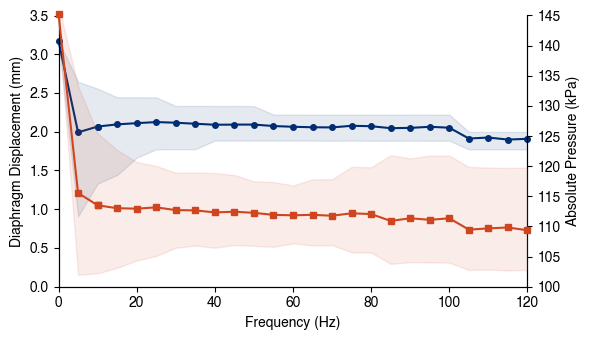

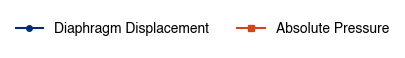

In [9]:
df = pd.read_csv("csv/Pneumatactors_Characterization.csv")

def plot_frequency_vs_disp_and_pressure(df, pump_pwm):
    v_pump = round(pump_pwm / 255 * 5, 2)
    filtered_df = df[df['pump_pwm'] == pump_pwm]

    freq = filtered_df['frequency']

    fig, ax1 = plt.subplots(figsize=figsize)

    # Left y-axis: Displacement
    disp_mean = filtered_df['mean_disp_mm']
    disp_min = filtered_df['min_disp_mm']
    disp_max = filtered_df['max_disp_mm']
    
    ax1.fill_between(freq, disp_min, disp_max, color=jhu_hex_colors["Heritage Blue"], alpha=0.1)
    disp_line, = ax1.plot(freq, disp_mean, color=jhu_hex_colors["Heritage Blue"], marker='o', markersize=4, label='Diaphragm Displacement', clip_on=False)
    ax1.set_xlabel("Frequency (Hz)")
    ax1.set_ylabel("Diaphragm Displacement (mm)")
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.set_xlim(0, 120) 
    ax1.set_ylim([0, 3.5])

    # Right y-axis: Pressure
    ax2 = ax1.twinx()
    pressure_mean = filtered_df['mean_pressure'] + 101.325
    pressure_min = filtered_df['min_pressure'] + 101.325
    pressure_max = filtered_df['max_pressure'] + 101.325
    
    ax2.fill_between(freq, pressure_min, pressure_max, color=jhu_hex_colors["Red"], alpha=0.1)
    pressure_line, = ax2.plot(freq, pressure_mean, color=jhu_hex_colors["Red"], marker='s', markersize=4, label='Absolute Pressure', clip_on=False)
    ax2.set_ylabel("Absolute Pressure (kPa)")
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.set_ylim([100, 145])

    # Legend (only lines)
    handles = [disp_line, pressure_line]
    labels = [h.get_label() for h in handles]

    # hide top and right spines
    ax1.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    # plt.title(f"Frequency vs. Displacement and Pressure (V_pump = {v_pump} V)")

    # Send both axes (spines, ticks) to the back
    for spine in ax1.spines.values():
        spine.set_zorder(0)
    for spine in ax2.spines.values():
        spine.set_zorder(0)

    ax1.set_axisbelow(True)
    ax2.set_axisbelow(True)

    # Ensure ticks are below
    ax1.tick_params(zorder=0)
    ax2.tick_params(zorder=0)

    fig.tight_layout()
    plt.savefig(f"plots/Pneumatactor_FrequencySweep_PWM{pump_pwm}.pdf", dpi=300, bbox_inches='tight')
    plt.show()

    # Save legend separately
    legend_fig, legend_ax = plt.subplots(figsize=(3, 0.5))
    legend_ax.axis('off')

    legend = legend_ax.legend(
        handles, labels,
        loc='center',
        ncol=2,
        frameon=False,
        handlelength=2,
        fontsize=10
    )

    legend_fig.savefig("plots/legend.pdf", dpi=300, bbox_inches='tight', transparent=True)
    plt.show(legend_fig)

# Example use:
plot_frequency_vs_disp_and_pressure(df, 200)


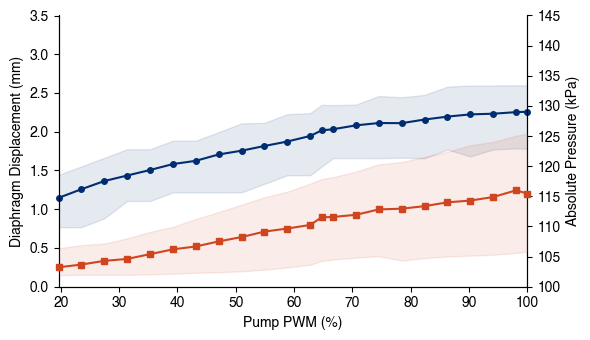

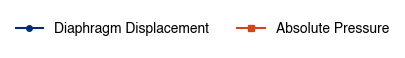

In [10]:
df = pd.read_csv("csv/Pneumatactors_Characterization.csv")

y_height = 0

def plot_pump_voltage_vs_disp_and_pressure(df, frequency=20):
    # Filter to one frequency
    filtered_df = df[df['frequency'] == frequency].copy()
    filtered_df["v_pump"] = (filtered_df['pump_pwm'] / 255 * 100).round(2)
    filtered_df = filtered_df.sort_values("v_pump")

    v_pump = filtered_df["v_pump"]
    
    fig, ax1 = plt.subplots(figsize=figsize)

    # Left y-axis: Displacement
    disp_mean = filtered_df['mean_disp_mm']
    disp_min = filtered_df['min_disp_mm']
    disp_max = filtered_df['max_disp_mm']

    ax1.fill_between(v_pump, disp_min, disp_max, color=jhu_hex_colors["Heritage Blue"], alpha=0.1)
    disp_line, = ax1.plot(v_pump, disp_mean, color=jhu_hex_colors["Heritage Blue"],
                          marker='o', markersize=4, label='Diaphragm Displacement', clip_on=False)
    ax1.set_xlabel("Pump PWM (%)")
    ax1.set_ylabel("Diaphragm Displacement (mm)")
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.set_xlim(min(v_pump), max(v_pump))  # pad both sides to avoid clipping
    ax1.set_ylim([0, 3.5])

    # Right y-axis: Pressure
    ax2 = ax1.twinx()
    pressure_mean = filtered_df['mean_pressure'] + 101.325
    pressure_min = filtered_df['min_pressure'] + 101.325
    pressure_max = filtered_df['max_pressure'] + 101.325

    ax2.fill_between(v_pump, pressure_min, pressure_max, color=jhu_hex_colors["Red"], alpha=0.1)
    pressure_line, = ax2.plot(v_pump, pressure_mean, color=jhu_hex_colors["Red"],
                              marker='s', markersize=4, label='Absolute Pressure', clip_on=False)
    ax2.set_ylabel("Absolute Pressure (kPa)")
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.set_ylim([100, 145])

    # Legend (only lines)
    handles = [disp_line, pressure_line]
    labels = [h.get_label() for h in handles]
    # Clean up spines
    ax1.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    for spine in ax1.spines.values():
        spine.set_zorder(0)
    for spine in ax2.spines.values():
        spine.set_zorder(0)

    ax1.set_axisbelow(True)
    ax2.set_axisbelow(True)
    ax1.tick_params(zorder=0)
    ax2.tick_params(zorder=0)

    fig.tight_layout()

    plt.savefig(f"plots/Pneumatactor_PWMSweep_Freq{frequency}.pdf", dpi=300, bbox_inches='tight')
    plt.show()

    # Save legend separately
    legend_fig, legend_ax = plt.subplots(figsize=(3, 0.5))
    legend_ax.axis('off')

    legend = legend_ax.legend(
        handles, labels,
        loc='center',
        ncol=2,
        frameon=False,
        handlelength=2,
        fontsize=10
    )

    legend_fig.savefig("plots/legend.pdf", dpi=300, bbox_inches='tight', transparent=True)
    plt.show(legend_fig)

# Example usage:
plot_pump_voltage_vs_disp_and_pressure(df, frequency=20)

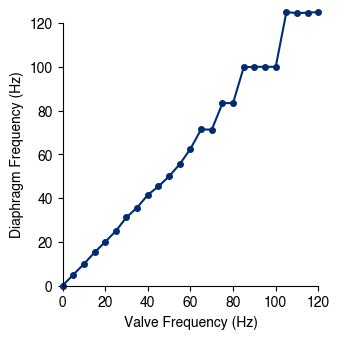

In [12]:
df = pd.read_csv("csv/Pneumatactors_Characterization_FrequencyValidation.csv")

def plot_disp_freq_vs_valve_freq(df):
    fig, ax = plt.subplots(figsize=(figsize[1], figsize[1]))

    # Plotting
    ax.plot(df['valve_freq_hz'], df['disp_freq_hz'], marker='o', markersize=4, color=jhu_hex_colors["Heritage Blue"], clip_on=False)
    ax.set_xlabel("Valve Frequency (Hz)")
    ax.set_ylabel("Diaphragm Frequency (Hz)")
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 120)

    # Hide top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    fig.tight_layout()
    plt.savefig("plots/Pneumatactor_FrequencyValidation.pdf", dpi=300, bbox_inches='tight')
    plt.show()

# Example usage:
plot_disp_freq_vs_valve_freq(df)

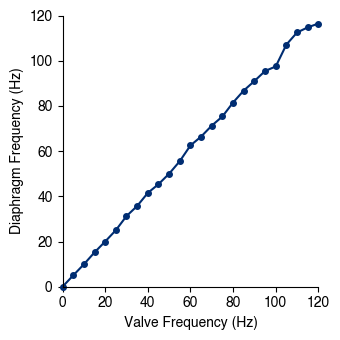

In [25]:
df = pd.read_csv("csv/Pneumatactors_Characterization_FrequencyValidationDummy.csv")

def plot_disp_freq_vs_valve_freq(df):
    fig, ax = plt.subplots(figsize=(figsize[1], figsize[1]))

    # Plotting
    ax.plot(df['valve_freq_hz'], df['disp_freq_hz'], marker='o', markersize=4, color=jhu_hex_colors["Heritage Blue"], clip_on=False)
    ax.set_xlabel("Valve Frequency (Hz)")
    ax.set_ylabel("Diaphragm Frequency (Hz)")
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 120)

    # Hide top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    fig.tight_layout()
    plt.savefig("plots/Pneumatactor_FrequencyValidation.pdf", dpi=300, bbox_inches='tight')
    plt.show()

# Example usage:
plot_disp_freq_vs_valve_freq(df)

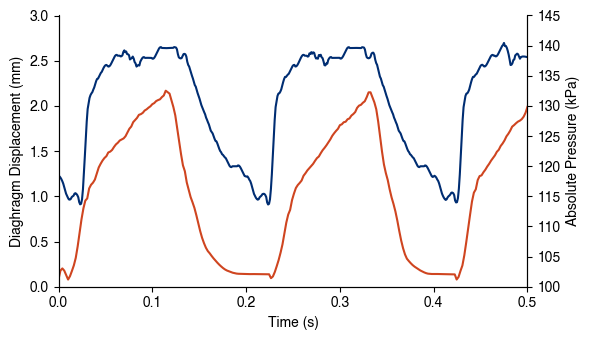

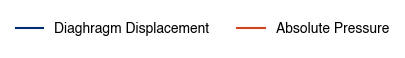

In [20]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# === PARAMETERS ===
pump_pwm = 200
frequency = 5
camera = "C001H001S0001"
fps = 1000

# === PATH SETUP ===
freq_str = str(frequency).zfill(3)
pwm_str = str(pump_pwm).zfill(3)
base_name = f"{freq_str}_{pwm_str}_{camera}"
image_folder = os.path.join("Photron Images", base_name)
analog_file = os.path.join("Analog Data", f"{freq_str}_{pwm_str}.csv")

try:
    import cv2

    # === UTILITY FUNCTIONS ===
    def voltage_to_pressure(vout):
        return (vout / 5 - 0.04) / 0.009

    def extract_displacement_time_series(folder, base_file, fps):
        top_distances_mm = []
        for img in range(1, 501):
            filename = os.path.join(folder, base_file + str(img).zfill(6) + ".bmp")
            if not os.path.exists(filename):
                filename = os.path.join(folder, base_file + str(img).zfill(6) + ".png")
                if not os.path.exists(filename):
                    continue

            image = cv2.imread(filename)
            if image is None:
                continue

            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            cropped = gray[480:600, 455:535]
            blurred = cv2.GaussianBlur(cropped, (5, 5), 0)
            edges = cv2.Canny(blurred, threshold1=5, threshold2=130)

            edge_points = np.column_stack(np.where(edges > 0))
            if edge_points.size == 0:
                top_distances_mm.append(np.nan)
                continue

            ys = edge_points[:, 0]
            try:
                avg_bottom_y = np.mean(ys[ys > (edges.shape[0] - 20)])
                avg_middle_y = np.mean(ys[(ys > 40) & (ys < 60)])
                peak_top_y = np.min(ys[ys < 40])
                pixels_per_mm = (avg_bottom_y - avg_middle_y) / 7.2
                top_distance_mm = (avg_middle_y - peak_top_y) / pixels_per_mm
                top_distances_mm.append(top_distance_mm)
            except:
                top_distances_mm.append(np.nan)

        disp_time = np.linspace(0, 0.5, len(top_distances_mm))
        return disp_time, top_distances_mm

    # === LOAD PRESSURE FROM ANALOG ===
    if not os.path.exists(analog_file):
        raise FileNotFoundError(f"Analog file not found: {analog_file}")

    df = pd.read_csv(analog_file)
    if 'Channel_3' not in df or 'Channel_4' not in df:
        raise ValueError("Analog file missing required columns.")

    camera_on = df['Channel_4'] >= 4.5
    if not camera_on.any():
        raise ValueError("No camera trigger found in analog data.")

    start_idx = camera_on.idxmax()
    start_time = df.loc[start_idx, 'Time']
    end_time = start_time + 0.5
    recording = df[(df['Time'] >= start_time) & (df['Time'] <= end_time)]

    pressure_vals = voltage_to_pressure(recording['Channel_3'].values)
    pressure_time = np.linspace(0, 0.5, len(pressure_vals))  # Force x-axis to 0–0.5s

    # === LOAD DISPLACEMENT FROM IMAGES ===
    disp_time, disp_vals = extract_displacement_time_series(image_folder, base_name, fps)

    # Low pass filter the displacement data and the pressure data
    disp_vals = savgol_filter(disp_vals, window_length=11, polyorder=3)
    pressure_vals = savgol_filter(pressure_vals, window_length=11, polyorder=3)  + 101.325
    # Normalize the pressure data to match the displacement scale

    # Save the processed data
    disp_df = pd.DataFrame({
        'Time': disp_time,
        'Displacement (mm)': disp_vals
    })
    pressure_df = pd.DataFrame({
        'Time': pressure_time,
        'Pressure (kPa)': pressure_vals
    })
    disp_df.to_csv(f"csv/{base_name}_displacement.csv", index=False)
    pressure_df.to_csv(f"csv/{base_name}_pressure.csv", index=False)

except ImportError:
    # Load the processed data for plotting
    disp_df = pd.read_csv(f"csv/{base_name}_displacement.csv")
    pressure_df = pd.read_csv(f"csv/{base_name}_pressure.csv")
    disp_time = disp_df['Time'].values
    disp_vals = disp_df['Displacement (mm)'].values
    pressure_time = pressure_df['Time'].values
    pressure_vals = pressure_df['Pressure (kPa)'].values

# === PLOT ===
fig, ax1 = plt.subplots(figsize=figsize)

# Displacement axis
ax1.set_xlabel("Time (s)", color='black')
ax1.set_ylabel("Diaghragm Displacement (mm)", color='black')
disp_line, = ax1.plot(
    disp_time, disp_vals,
    color=jhu_hex_colors["Heritage Blue"],
    label="Diaghragm Displacement"
)
ax1.tick_params(axis='x', labelcolor='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xlim(0, 0.5)
ax1.set_ylim(0, 3)

# Set spine colors for ax1
for spine in ['left', 'bottom', 'right', 'top']:
    ax1.spines[spine].set_color('black')
ax1.spines['top'].set_visible(False)

# Pressure axis
ax2 = ax1.twinx()
ax2.set_ylabel("Absolute Pressure (kPa)", color='black')
pressure_line, = ax2.plot(
    pressure_time, pressure_vals,
    color=jhu_hex_colors["Red"],
    label="Absolute Pressure"
)
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim(100, 145)

# Set spine colors for ax2
ax2.spines['right'].set_color('black')
ax2.spines['bottom'].set_color('black')
ax2.spines['top'].set_visible(False)

fig.tight_layout()
# Transparent backgrounds
fig.patch.set_alpha(0.0)
ax1.set_facecolor('none')
ax2.set_facecolor('none')

# Save figure
plt.savefig(f"plots/{base_name}_displacement_pressure.pdf", dpi=300, bbox_inches='tight')
plt.show()

# === LEGEND ===
legend_fig, legend_ax = plt.subplots(figsize=(3, 0.5))
legend_ax.axis('off')

legend = legend_ax.legend(
    handles=[disp_line, pressure_line],
    labels=[disp_line.get_label(), pressure_line.get_label()],
    loc='center',
    ncol=2,
    frameon=False,
    handlelength=2,
    fontsize=10
)

legend_fig.savefig(f"plots/{base_name}_legend.pdf", dpi=300, bbox_inches='tight', transparent=True)


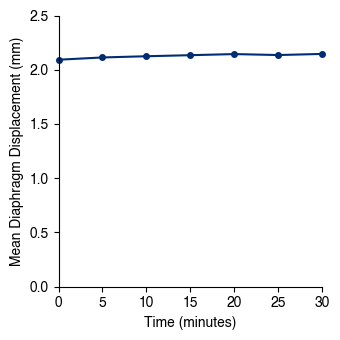

In [23]:
df = pd.read_csv("csv/Pneumatactors_Characterization_DiaphragmRepeating.csv")

def plot_time_vs_displacement(df):
    fig, ax = plt.subplots(figsize=(figsize[1], figsize[1]))

    # Plotting
    ax.plot(df['time_mins'], df['displacement_mm'], marker='o', markersize=4, color=jhu_hex_colors["Heritage Blue"], clip_on=False)
    ax.set_xlabel("Time (minutes)")
    ax.set_ylabel("Mean Diaphragm Displacement (mm)")
    ax.set_xlim(0, 30)
    ax.set_ylim(0, 2.5)

    # Hide top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    fig.tight_layout()
    plt.savefig("plots/Pneumatactor_DiaphragmRepeating.pdf", dpi=300, bbox_inches='tight')
    plt.show()

# Example usage:
plot_time_vs_displacement(df)